In [1]:
import os
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

In [2]:
# Initialise HooMD
hoomd.context.initialize("")
hoomd.option.set_notice_level(1)

HOOMD-blue 2.7.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 10/02/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [3]:
# Generate RNG seed
rng_seed = os.urandom(4)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 946241626


In [4]:
# Simulate a single chromosome comprised of 10 1500-monomer-long repeat units with number density 0.2
n_beads = 1500
n_rep = 10
density = 0.2

In [5]:
# Setup initial simulation snapshot in spherical confinement
snap = build.get_init_snapshot(n_beads, n_rep, density, confine=True, mode_init="cubic")

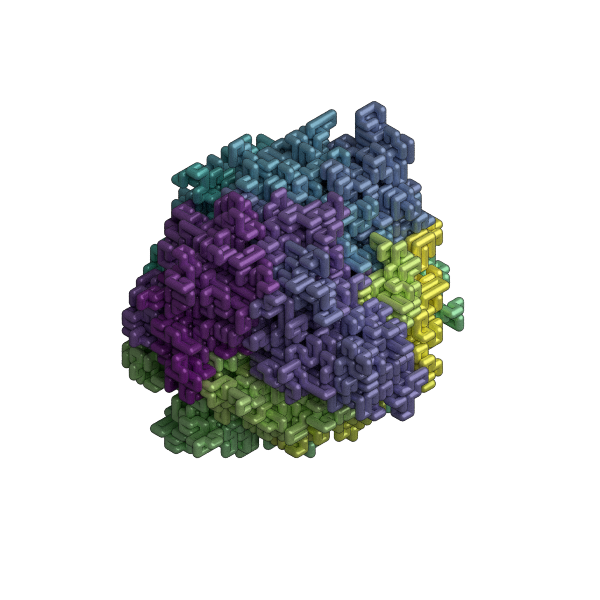

In [6]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snap, pathtrace=True)

In [7]:
# Setup HooMD simulation object
system = hoomd.init.read_snapshot(snap)

In [8]:
# Setup neighbor list
nl = hoomd.md.nlist.cell()

In [9]:
# Set chromosome excluded volume
poly_exc = forces.set_excluded_volume(nl, mode_integ='langevin')

In [10]:
# Set bonded potentials
bond_harm = forces.set_poly_bonds()
angle_kg = forces.set_poly_angles()

In [11]:
# Set spherical confining wall
R = (3*n_beads*n_rep / (4*np.pi*density))**(1/3.)
wall_force_slj = forces.set_SLJ_sphere(R)

In [12]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [13]:
# Initialize integrators and Langevin thermostat
hoomd.md.integrate.mode_standard(dt=7*t_conv)
langevin = hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=rng_seed)

In [14]:
# Run
hoomd.run(2e4)

** starting run **
Time 00:00:10 | Step 1641 / 20000 | TPS 163.906 | ETA 00:01:52
Time 00:00:20 | Step 3401 / 20000 | TPS 175.707 | ETA 00:01:34
Time 00:00:30 | Step 5092 / 20000 | TPS 169.038 | ETA 00:01:28
Time 00:00:40 | Step 6927 / 20000 | TPS 183.417 | ETA 00:01:11
Time 00:00:50 | Step 8747 / 20000 | TPS 181.986 | ETA 00:01:01
Time 00:01:00 | Step 10650 / 20000 | TPS 190.246 | ETA 00:00:49
Time 00:01:10 | Step 12353 / 20000 | TPS 170.267 | ETA 00:00:44
Time 00:01:20 | Step 14291 / 20000 | TPS 193.786 | ETA 00:00:29
Time 00:01:30 | Step 16262 / 20000 | TPS 197.046 | ETA 00:00:18
Time 00:01:40 | Step 18132 / 20000 | TPS 186.923 | ETA 00:00:09
Time 00:01:49 | Step 20000 / 20000 | TPS 196.876 | ETA 00:00:00
Average TPS: 182.583
---------
-- Neighborlist stats:
1890 normal updates / 200 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 9 / n_neigh_avg: 1.12713
shortest rebuild period: 8
-- Cell list stats:
Dimension: 74, 74, 74
n_min    : 0 / n_max: 6 / n_avg: 0.037016

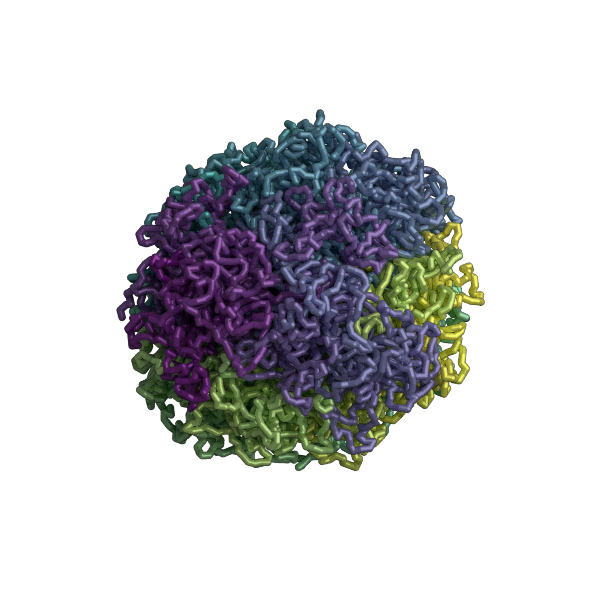

In [15]:
# Visualize new conformation
snap = system.take_snapshot(all=True)
render.fresnel(snap, pathtrace=True)

In [16]:
# Set up domains by assigning monomers to a type 0 (A) or 1 (B)
domains = np.zeros(n_beads)
domains[n_beads//3:2*n_beads//3] = 1

snap.particles.typeid[:] = np.tile(domains, n_rep)

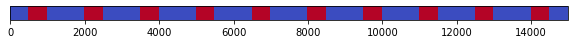

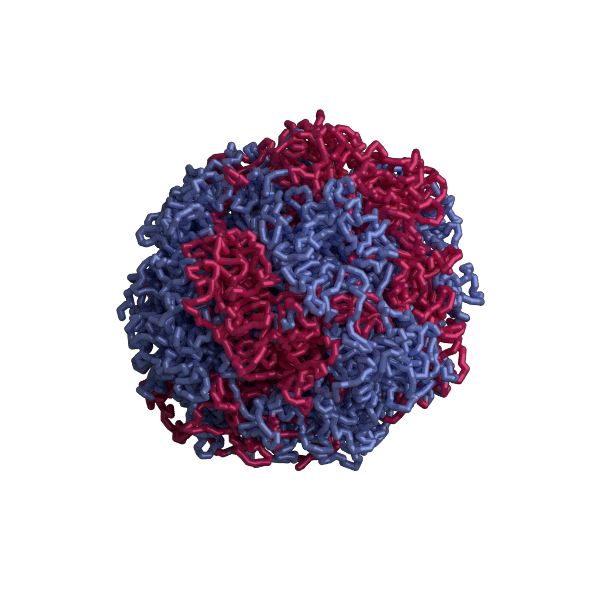

In [17]:
# Visualize domains in 1D and 3D
render.domain_viewer(snap, cmap="coolwarm")
render.fresnel(snap, pathtrace=True, show_compartments=True, cmap="coolwarm")

In [18]:
# Load updated snapshot
system.restore_snapshot(snap)

In [19]:
# Set specific attraction between B-type monomers
poly_att = forces.set_PSW_attraction(nl)

In [20]:
# Set DPD integrator
poly_exc.disable()
langevin.disable()

poly_dpd = forces.set_excluded_volume(nl, mode_integ="dpd", seed=rng_seed)
nve = hoomd.md.integrate.nve(group=hoomd.group.all())

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----


In [21]:
# Run
hoomd.run(2e4)

** starting run **
Time 00:03:05 | Step 21552 / 40000 | TPS 155.168 | ETA 00:01:58
Time 00:03:15 | Step 23028 / 40000 | TPS 147.575 | ETA 00:01:55
Time 00:03:25 | Step 24461 / 40000 | TPS 143.253 | ETA 00:01:48
Time 00:03:35 | Step 25788 / 40000 | TPS 132.562 | ETA 00:01:47
Time 00:03:45 | Step 27198 / 40000 | TPS 140.9 | ETA 00:01:30
Time 00:03:55 | Step 28536 / 40000 | TPS 133.649 | ETA 00:01:25
Time 00:04:05 | Step 29836 / 40000 | TPS 129.997 | ETA 00:01:18
Time 00:04:15 | Step 31106 / 40000 | TPS 126.788 | ETA 00:01:10
Time 00:04:25 | Step 32405 / 40000 | TPS 129.852 | ETA 00:00:58
Time 00:04:35 | Step 33612 / 40000 | TPS 120.648 | ETA 00:00:52
Time 00:04:45 | Step 34901 / 40000 | TPS 128.71 | ETA 00:00:39
Time 00:04:55 | Step 36206 / 40000 | TPS 130.336 | ETA 00:00:29
Time 00:05:05 | Step 37484 / 40000 | TPS 127.64 | ETA 00:00:19
Time 00:05:15 | Step 38733 / 40000 | TPS 124.843 | ETA 00:00:10
Time 00:05:25 | Step 40000 / 40000 | TPS 135.53 | ETA 00:00:00
Average TPS: 133.82
------

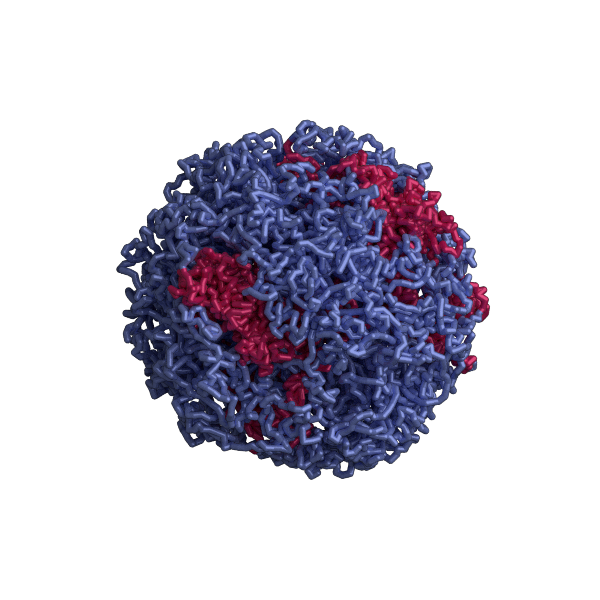

In [22]:
# Visualize new conformation
snap = system.take_snapshot(all=True)
render.fresnel(snap, pathtrace=True, show_compartments=True, cmap="coolwarm")